# PyTorch & MNIST Intro

Let's go through a simple example of Pytorch and MNIST as a way to level set NNs and the use of notebooks.

In [1]:
import torch
import torchvision
import matplotlib.pyplot as pl
import random
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

## Dataset

MNIST is probably the most traditionally used dataset for neural networks, as it is a relatively challenging problem in computer vision: recognizing single-digit numbers from a hand-written digital format. Classically, this dataset takes the form of samples of $28 \times 28$ matrices.

In [32]:
batch_size_train = 64
batch_size_test = 1000

In [33]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test,
    shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

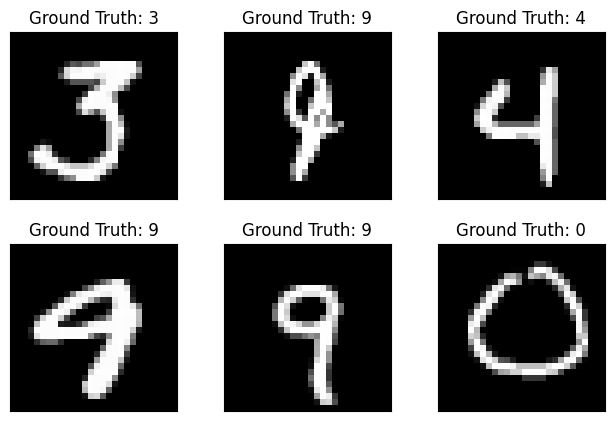

In [5]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Ground Truth: {}".format(example_targets[i]))
    pl.xticks([])
    pl.yticks([])
pl.show()

## Building the model

We need to specify the model through a Python class. Below we show how to create a Feedforward Neural Network model using Pytorch.

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self):
        input_dim = 28*28
        num_classes = 10
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes) 

    def forward(self, x):
        out = self.fc1(x)
        return F.log_softmax(out)

You'll need to instantiate this class as well as an optimizer, which will apply an algorithm to find the internal parameters of that model, such as matrix weights and biases. As an example, we will use the Stochastic Gradient Descent algorithm.

In [8]:
learning_rate = 0.001
momentum = 0.1
log_interval = 10

In [9]:
network = FeedforwardNeuralNetModel()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

## Training

Next, we will define the training procedure.

In [10]:
n_epochs = 5

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [11]:
! mkdir -p results

In [12]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration-{epoch}.pth')

In [13]:
train(1)

/var/folders/xy/dc9cct710_3fw4sk4kwnptnm0000gn/T/ipykernel_25861/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.462653
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.314634
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.172709
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.038150
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.011766
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.793893
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.784095
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.759681
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.595977
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.612938
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.453784
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.386518
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.438524
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.395226
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.237687
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.228426
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.189160
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.303519
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.156207
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.144378
Train Epoch: 1 [12800/60000 (

<br />
Alongside trainig, we will also monitor the performance of the model on a set of samples not seen during the training.

In [14]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [15]:
test()

/var/folders/xy/dc9cct710_3fw4sk4kwnptnm0000gn/T/ipykernel_25861/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/Users/mohit/opt/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5596, Accuracy: 8696/10000 (87%)



## Training and evaluating for multiple epochs

Let's train now for all desired epochs.

In [16]:
for epoch in range(2, n_epochs + 1): # starts from the second iteration
  train(epoch)
  test()

/var/folders/xy/dc9cct710_3fw4sk4kwnptnm0000gn/T/ipykernel_25861/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 2 [0/60000 (0%)]	Loss: 0.666574
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.541078
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.564097
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.666229
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.488056
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.434858
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.543594
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.447622
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.549790
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.652385
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.670172
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.586397
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.554512
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.585009
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.654413
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.667827
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.639856
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.650934
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.545639
Train Epoch: 2 [12160/60000 (20%)]	Loss: 0.532475
Train Epoch: 2 [12800/60000 (

Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.527041
Train Epoch: 3 [45440/60000 (76%)]	Loss: 0.536015
Train Epoch: 3 [46080/60000 (77%)]	Loss: 0.342275
Train Epoch: 3 [46720/60000 (78%)]	Loss: 0.588448
Train Epoch: 3 [47360/60000 (79%)]	Loss: 0.269670
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.278183
Train Epoch: 3 [48640/60000 (81%)]	Loss: 0.388054
Train Epoch: 3 [49280/60000 (82%)]	Loss: 0.243378
Train Epoch: 3 [49920/60000 (83%)]	Loss: 0.693933
Train Epoch: 3 [50560/60000 (84%)]	Loss: 0.393076
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.275795
Train Epoch: 3 [51840/60000 (86%)]	Loss: 0.332906
Train Epoch: 3 [52480/60000 (87%)]	Loss: 0.551176
Train Epoch: 3 [53120/60000 (88%)]	Loss: 0.606337
Train Epoch: 3 [53760/60000 (90%)]	Loss: 0.359024
Train Epoch: 3 [54400/60000 (91%)]	Loss: 0.488740
Train Epoch: 3 [55040/60000 (92%)]	Loss: 0.446344
Train Epoch: 3 [55680/60000 (93%)]	Loss: 0.345604
Train Epoch: 3 [56320/60000 (94%)]	Loss: 0.580558
Train Epoch: 3 [56960/60000 (95%)]	Loss: 0.497443


Train Epoch: 5 [30080/60000 (50%)]	Loss: 0.335787
Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.338214
Train Epoch: 5 [31360/60000 (52%)]	Loss: 0.307868
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.311590
Train Epoch: 5 [32640/60000 (54%)]	Loss: 0.285531
Train Epoch: 5 [33280/60000 (55%)]	Loss: 0.375049
Train Epoch: 5 [33920/60000 (57%)]	Loss: 0.417083
Train Epoch: 5 [34560/60000 (58%)]	Loss: 0.372412
Train Epoch: 5 [35200/60000 (59%)]	Loss: 0.619531
Train Epoch: 5 [35840/60000 (60%)]	Loss: 0.277805
Train Epoch: 5 [36480/60000 (61%)]	Loss: 0.466849
Train Epoch: 5 [37120/60000 (62%)]	Loss: 0.486229
Train Epoch: 5 [37760/60000 (63%)]	Loss: 0.309154
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.404888
Train Epoch: 5 [39040/60000 (65%)]	Loss: 0.453257
Train Epoch: 5 [39680/60000 (66%)]	Loss: 0.361263
Train Epoch: 5 [40320/60000 (67%)]	Loss: 0.295195
Train Epoch: 5 [40960/60000 (68%)]	Loss: 0.412795
Train Epoch: 5 [41600/60000 (69%)]	Loss: 0.414311
Train Epoch: 5 [42240/60000 (70%)]	Loss: 0.428503


# Model performance

Finally, we can inspect the results.

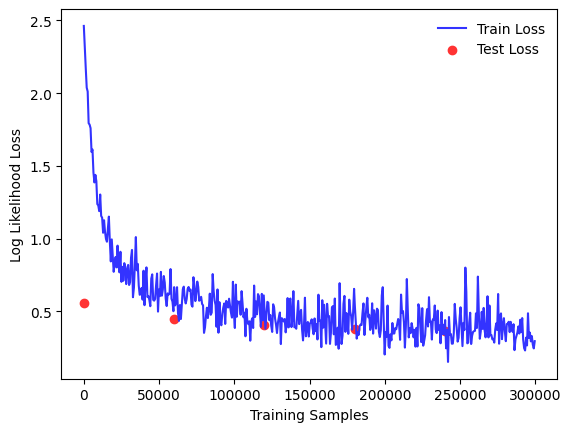

In [17]:
fig = pl.figure()
pl.plot(train_counter, train_losses, color=(0.2, 0.2, 1.0))
pl.scatter(test_counter[:-1], test_losses, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

It's always important to inspect anecdotes to convince yourself the model is behind as expected.

In [18]:
with torch.no_grad():
  output = network(example_data.reshape(1000, 28*28))

/var/folders/xy/dc9cct710_3fw4sk4kwnptnm0000gn/T/ipykernel_25861/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


**Challenge:** Can you explain why we are using `torch.no_grad()`?

**Answer:** Since we are doing inference, we won't be calling `torch.backward()` to perform backpropagation and calculate gradients. `torch.no_grad` disables gradient calculation in order to reduce memory consumption.

In [19]:
output.data

tensor([[ -8.6875, -10.5132,  -9.2775,  ...,  -8.4409,  -7.4675, -10.2256],
        [ -9.1144,  -2.4974,  -3.4454,  ...,  -2.7732,  -2.3991,  -0.7810],
        [ -8.7062, -12.1838,  -8.0954,  ...,  -6.0701,  -7.3619,  -2.7955],
        ...,
        [ -9.6310,  -7.4897,  -9.8215,  ...,  -5.9149,  -4.9771,  -0.7510],
        [ -7.4488,  -8.3181,  -6.1933,  ...,  -0.4986,  -5.4990,  -1.2440],
        [ -7.5585,  -8.7178,  -3.8631,  ...,  -6.9077,  -6.8742,  -6.6210]])

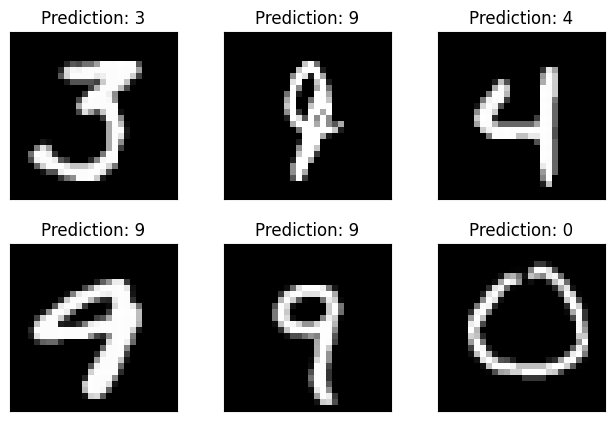

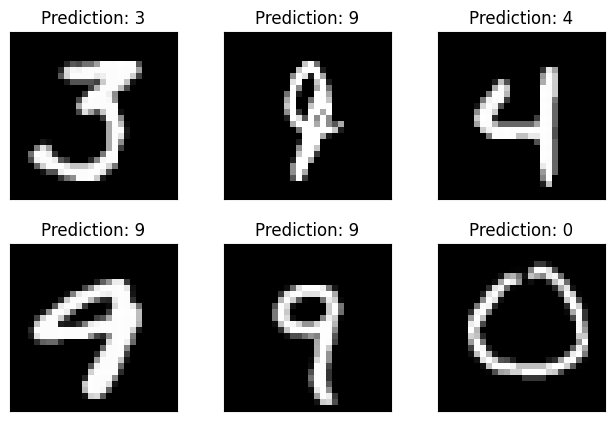

In [20]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    pl.xticks([])
    pl.yticks([])
fig

**Challenge:** Re-do the plot above, but showcasing only miss-classifications (i.e. cases in which the model did wrong).

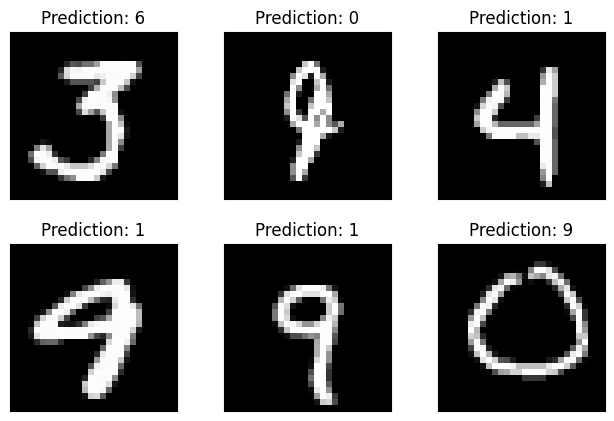

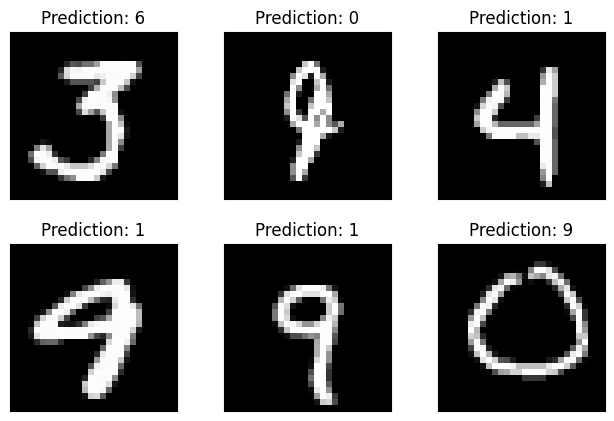

In [21]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Prediction: {}".format(output.data.min(1, keepdim=True)[1][i].item()))
    pl.xticks([])
    pl.yticks([])
fig

## Loading trained models

Eventually, you will want to load the model you trained in the past for either running inference or continue the training procedure. The functions we developed above save artifacts contain all of the metadata and data about the model, assuming you have the right model class. Let's inspect those files: 

In [22]:
! ls results

model_iteration-1.pth     model_iteration-5.pth     optimizer_iteration-4.pth
model_iteration-2.pth     optimizer_iteration-1.pth optimizer_iteration-5.pth
model_iteration-3.pth     optimizer_iteration-2.pth
model_iteration-4.pth     optimizer_iteration-3.pth


To load a model:

In [23]:
trained_model = FeedforwardNeuralNetModel()
model_state_dict = torch.load("results/model_iteration-1.pth")
trained_model.load_state_dict(model_state_dict)

<All keys matched successfully>

Before proceeding, let's inspect `model_state_dict`

In [24]:
model_state_dict.keys()

odict_keys(['fc1.weight', 'fc1.bias'])

In [25]:
model_state_dict['fc1.weight'].shape

torch.Size([10, 784])

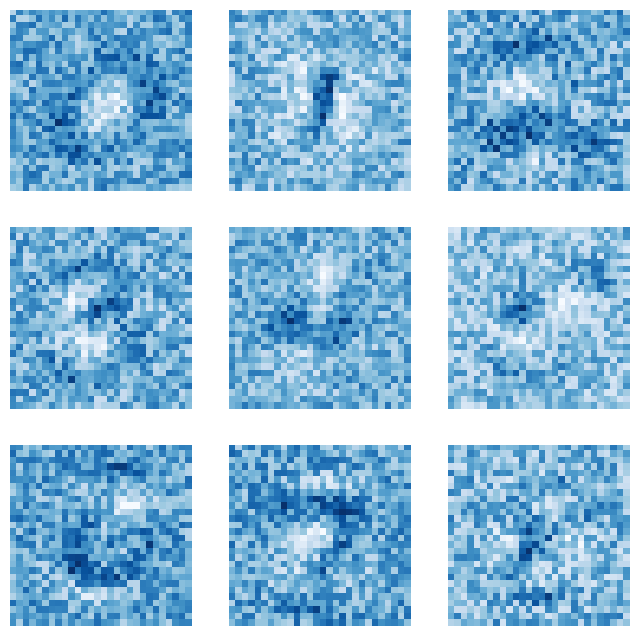

In [26]:
f,axs = pl.subplots(3,3, figsize=(8,8))

c = 0
for ax in axs:
    for sax in ax:
        sax.imshow(model_state_dict['fc1.weight'][c].reshape((28,28)), 
                   cmap = pl.get_cmap('Blues'))
        c += 1
        sax.axis('off')

pl.show()

Let's do the same for the optimizer

In [27]:
optimizer = optim.SGD(trained_model.parameters(), lr=learning_rate, momentum=momentum)
optimizer_state_dict = torch.load("results/optimizer_iteration-3.pth")
optimizer.load_state_dict(optimizer_state_dict)

In [28]:
optimizer_state_dict.keys()

dict_keys(['state', 'param_groups'])

**Challenge:** Can you make sense of the data in this dictionary?

**Answer:** This dictionary contains two values, the current optimization state and the list of all parameter groups. A state is saved per parameter and the `param_groups` contains the various metadata specific to the optimizer.

## Final challenges

* What happens if you use only 10% of the available training data? Plot the difference in performance of the network.
* **Ans:** After plotting the performance, the test accuracy seems to be about the same (90%). However, in general using less training data means decreased performance since the model has fewer examples to learn from. It's better to use as much training data as available.


* What happens if you remove 80% of all samples with label 5. Do you see a difference in performance? Is this difference homogeneous?
* **Ans:** Similar to the previous question, the test accuracy didn't seem to change much (it remains at around 90%). However, testing performance would decrease when there's fewer examples of a specific output class because the model can't generalize as well as compared to the other classes. In other words, as stated in the previous question, using less training data is expected to lead to a decrease in performance, especially when predicting data with a label of 5.


* What happens if you change parameters like the learning rate and momentum? Plot the difference.

* Can you add more layers to this neural network? Start with one additional layer (often called "hidden layer"). What changes can you observe in doing so?
* **Ans:** Adding more layers to the neural network increases the complexity of the model and allows it learn more intricate patterns and differences. In turn, this can increase the performance of the model since it is able to predict more accurately. However, it can also have a negative effect by overfitting to the training data and generalizing poorly on test data.


* Can you add regularization to this model? Look for L1, L2, and drop-out regularizations. What changes do you observe?
* [stretch] Can you change this model and turn it into a convolutional neural network?

#### Question 1

In [29]:
trainset = torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ]))
train_data = torch.utils.data.Subset(trainset, list(range(0, 6000)))

/var/folders/xy/dc9cct710_3fw4sk4kwnptnm0000gn/T/ipykernel_21885/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 2 [0/6000 (0%)]	Loss: 0.200403
Train Epoch: 2 [640/6000 (11%)]	Loss: 0.451929
Train Epoch: 2 [1280/6000 (21%)]	Loss: 0.420959
Train Epoch: 2 [1920/6000 (32%)]	Loss: 0.239907
Train Epoch: 2 [2560/6000 (43%)]	Loss: 0.322430
Train Epoch: 2 [3200/6000 (53%)]	Loss: 0.736370
Train Epoch: 2 [3840/6000 (64%)]	Loss: 0.259079
Train Epoch: 2 [4480/6000 (74%)]	Loss: 0.178597
Train Epoch: 2 [5120/6000 (85%)]	Loss: 0.554644
Train Epoch: 2 [5760/6000 (96%)]	Loss: 0.258029

Test set: Avg. loss: 0.3646, Accuracy: 9015/10000 (90%)

Train Epoch: 3 [0/6000 (0%)]	Loss: 0.364796
Train Epoch: 3 [640/6000 (11%)]	Loss: 0.389560
Train Epoch: 3 [1280/6000 (21%)]	Loss: 0.307209
Train Epoch: 3 [1920/6000 (32%)]	Loss: 0.364684
Train Epoch: 3 [2560/6000 (43%)]	Loss: 0.306190
Train Epoch: 3 [3200/6000 (53%)]	Loss: 0.251423
Train Epoch: 3 [3840/6000 (64%)]	Loss: 0.289914
Train Epoch: 3 [4480/6000 (74%)]	Loss: 0.357786
Train Epoch: 3 [5120/6000 (85%)]	Loss: 0.501937
Train Epoch: 3 [5760/6000 (96%)]	Loss: 0

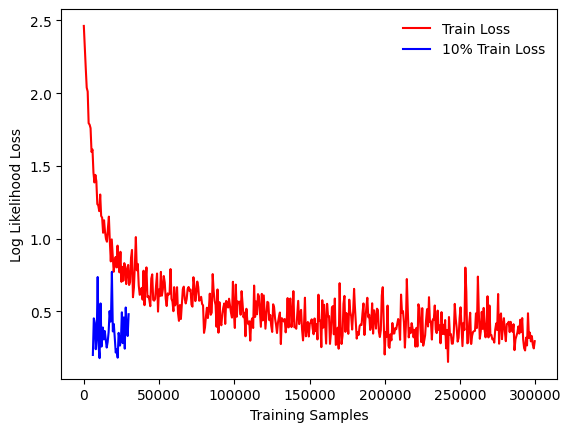

In [30]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train,
                                            shuffle=True)
n_epochs = 5
train_losses_10 = []
train_counter_10 = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses_10.append(loss.item())
            train_counter_10.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration-{epoch}.pth')

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

# Train the data
for epoch in range(2, n_epochs + 1): # starts from the second iteration
  train(epoch)
  test()
    
fig = pl.figure()
pl.plot(train_counter, train_losses, color='red')
pl.plot(train_counter_10, train_losses_10, color='blue')

pl.legend(['Train Loss', '10% Train Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

#### Question 2

In [31]:
trainset = torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ]))

In [32]:
# get indices that correspond to label 5
label_5_indices = (trainset.targets == 5).nonzero(as_tuple=True)[0]

num_to_remove = int(0.8 * len(label_5_indices))
remove_indices = random.sample(label_5_indices.tolist(), num_to_remove)

mask = torch.ones(len(trainset), dtype=bool)
mask[remove_indices] = False

trainset.data = trainset.data[mask]
trainset.targets = trainset.targets[mask]

/var/folders/xy/dc9cct710_3fw4sk4kwnptnm0000gn/T/ipykernel_20839/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 2 [0/55664 (0%)]	Loss: 0.319004
Train Epoch: 2 [640/55664 (1%)]	Loss: 0.479263
Train Epoch: 2 [1280/55664 (2%)]	Loss: 0.313242
Train Epoch: 2 [1920/55664 (3%)]	Loss: 0.431390
Train Epoch: 2 [2560/55664 (5%)]	Loss: 0.404604
Train Epoch: 2 [3200/55664 (6%)]	Loss: 0.317527
Train Epoch: 2 [3840/55664 (7%)]	Loss: 0.294298
Train Epoch: 2 [4480/55664 (8%)]	Loss: 0.356729
Train Epoch: 2 [5120/55664 (9%)]	Loss: 0.265245
Train Epoch: 2 [5760/55664 (10%)]	Loss: 0.404049
Train Epoch: 2 [6400/55664 (11%)]	Loss: 0.341292
Train Epoch: 2 [7040/55664 (13%)]	Loss: 0.358105
Train Epoch: 2 [7680/55664 (14%)]	Loss: 0.442930
Train Epoch: 2 [8320/55664 (15%)]	Loss: 0.343955
Train Epoch: 2 [8960/55664 (16%)]	Loss: 0.379235
Train Epoch: 2 [9600/55664 (17%)]	Loss: 0.403995
Train Epoch: 2 [10240/55664 (18%)]	Loss: 0.502347
Train Epoch: 2 [10880/55664 (20%)]	Loss: 0.309700
Train Epoch: 2 [11520/55664 (21%)]	Loss: 0.367699
Train Epoch: 2 [12160/55664 (22%)]	Loss: 0.248436
Train Epoch: 2 [12800/55664 (

Train Epoch: 3 [49920/55664 (90%)]	Loss: 0.490900
Train Epoch: 3 [50560/55664 (91%)]	Loss: 0.202692
Train Epoch: 3 [51200/55664 (92%)]	Loss: 0.299554
Train Epoch: 3 [51840/55664 (93%)]	Loss: 0.457451
Train Epoch: 3 [52480/55664 (94%)]	Loss: 0.229731
Train Epoch: 3 [53120/55664 (95%)]	Loss: 0.415650
Train Epoch: 3 [53760/55664 (97%)]	Loss: 0.261304
Train Epoch: 3 [54400/55664 (98%)]	Loss: 0.505009
Train Epoch: 3 [55040/55664 (99%)]	Loss: 0.193305

Test set: Avg. loss: 0.3646, Accuracy: 9015/10000 (90%)

Train Epoch: 4 [0/55664 (0%)]	Loss: 0.222785
Train Epoch: 4 [640/55664 (1%)]	Loss: 0.307579
Train Epoch: 4 [1280/55664 (2%)]	Loss: 0.225984
Train Epoch: 4 [1920/55664 (3%)]	Loss: 0.393918
Train Epoch: 4 [2560/55664 (5%)]	Loss: 0.218330
Train Epoch: 4 [3200/55664 (6%)]	Loss: 0.209756
Train Epoch: 4 [3840/55664 (7%)]	Loss: 0.456196
Train Epoch: 4 [4480/55664 (8%)]	Loss: 0.340556
Train Epoch: 4 [5120/55664 (9%)]	Loss: 0.408500
Train Epoch: 4 [5760/55664 (10%)]	Loss: 0.334079
Train Epoch: 4 

Train Epoch: 5 [43520/55664 (78%)]	Loss: 0.320271
Train Epoch: 5 [44160/55664 (79%)]	Loss: 0.283947
Train Epoch: 5 [44800/55664 (80%)]	Loss: 0.360827
Train Epoch: 5 [45440/55664 (82%)]	Loss: 0.433471
Train Epoch: 5 [46080/55664 (83%)]	Loss: 0.399087
Train Epoch: 5 [46720/55664 (84%)]	Loss: 0.412477
Train Epoch: 5 [47360/55664 (85%)]	Loss: 0.383405
Train Epoch: 5 [48000/55664 (86%)]	Loss: 0.351990
Train Epoch: 5 [48640/55664 (87%)]	Loss: 0.322232
Train Epoch: 5 [49280/55664 (89%)]	Loss: 0.319482
Train Epoch: 5 [49920/55664 (90%)]	Loss: 0.320798
Train Epoch: 5 [50560/55664 (91%)]	Loss: 0.329342
Train Epoch: 5 [51200/55664 (92%)]	Loss: 0.438971
Train Epoch: 5 [51840/55664 (93%)]	Loss: 0.209054
Train Epoch: 5 [52480/55664 (94%)]	Loss: 0.350984
Train Epoch: 5 [53120/55664 (95%)]	Loss: 0.307764
Train Epoch: 5 [53760/55664 (97%)]	Loss: 0.267909
Train Epoch: 5 [54400/55664 (98%)]	Loss: 0.370091
Train Epoch: 5 [55040/55664 (99%)]	Loss: 0.378360

Test set: Avg. loss: 0.3646, Accuracy: 9015/10000

ValueError: x and y must be the same size

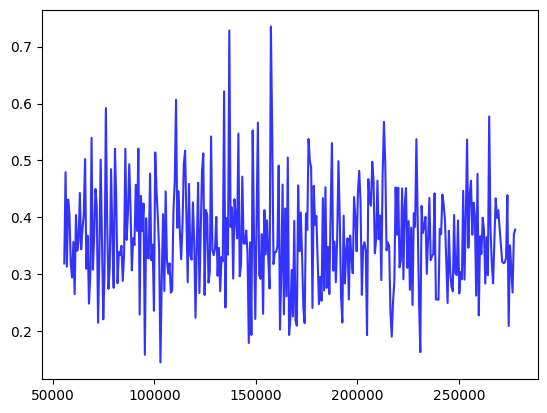

In [33]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train,
                                            shuffle=True)
n_epochs = 5
train_losses_5 = []
train_counter_5 = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses_5.append(loss.item())
            train_counter_5.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration-{epoch}.pth')

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

# Train the data
for epoch in range(2, n_epochs + 1): # starts from the second iteration
  train(epoch)
  test()
    
fig = pl.figure()
pl.plot(train_counter_5, train_losses_5, color=(0.2, 0.2, 1.0))
pl.scatter(test_counter[:-1], test_losses, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

#### Question 3

In [38]:
n_epochs = 5

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration-{epoch}.pth')

def test(loss_arr):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )
    loss_arr.append(test_loss)

In [39]:
learning_rate_values = [0.1, 0.001, 0.005, 0.0001]
momentum_vals = [1, 0.1, 0.01, 0.001]
log_interval = 10
losses_lr = []
losses_momentum = []

for learning_rate in learning_rate_values:
    momentum = 0.1
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
    
    network = FeedforwardNeuralNetModel()
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

    for epoch in range(2, n_epochs + 1): # starts from the second iteration
        train(epoch)
        test(losses_lr)
        
        
for momentum in momentum_vals:
    learning_rate = 0.001
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

    network = FeedforwardNeuralNetModel()
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

    for epoch in range(2, n_epochs + 1): # starts from the second iteration
        train(epoch)
        test(losses_momentum)

/var/folders/xy/dc9cct710_3fw4sk4kwnptnm0000gn/T/ipykernel_25861/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 2 [0/60000 (0%)]	Loss: 2.427740
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.713369
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.507478
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.566698
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.346443
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.350455
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.264960
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.349876
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.470275
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.492813
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.330760
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.446599
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.330440
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.478489
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.319093
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.489113
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.201808
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.187048
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.455109
Train Epoch: 2 [12160/60000 (20%)]	Loss: 0.304996
Train Epoch: 2 [12800/60000 (

Train Epoch: 3 [46080/60000 (77%)]	Loss: 0.356001
Train Epoch: 3 [46720/60000 (78%)]	Loss: 0.192378
Train Epoch: 3 [47360/60000 (79%)]	Loss: 0.314426
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.375892
Train Epoch: 3 [48640/60000 (81%)]	Loss: 0.434710
Train Epoch: 3 [49280/60000 (82%)]	Loss: 0.057910
Train Epoch: 3 [49920/60000 (83%)]	Loss: 0.240615
Train Epoch: 3 [50560/60000 (84%)]	Loss: 0.430529
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.247719
Train Epoch: 3 [51840/60000 (86%)]	Loss: 0.369708
Train Epoch: 3 [52480/60000 (87%)]	Loss: 0.175474
Train Epoch: 3 [53120/60000 (88%)]	Loss: 0.122461
Train Epoch: 3 [53760/60000 (90%)]	Loss: 0.118586
Train Epoch: 3 [54400/60000 (91%)]	Loss: 0.401873
Train Epoch: 3 [55040/60000 (92%)]	Loss: 0.180410
Train Epoch: 3 [55680/60000 (93%)]	Loss: 0.364955
Train Epoch: 3 [56320/60000 (94%)]	Loss: 0.607216
Train Epoch: 3 [56960/60000 (95%)]	Loss: 0.165349
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.117271
Train Epoch: 3 [58240/60000 (97%)]	Loss: 0.548703


Train Epoch: 5 [31360/60000 (52%)]	Loss: 0.635716
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.145698
Train Epoch: 5 [32640/60000 (54%)]	Loss: 0.158127
Train Epoch: 5 [33280/60000 (55%)]	Loss: 0.237538
Train Epoch: 5 [33920/60000 (57%)]	Loss: 0.210953
Train Epoch: 5 [34560/60000 (58%)]	Loss: 0.549581
Train Epoch: 5 [35200/60000 (59%)]	Loss: 0.639297
Train Epoch: 5 [35840/60000 (60%)]	Loss: 0.422002
Train Epoch: 5 [36480/60000 (61%)]	Loss: 0.341804
Train Epoch: 5 [37120/60000 (62%)]	Loss: 0.665987
Train Epoch: 5 [37760/60000 (63%)]	Loss: 0.272287
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.383635
Train Epoch: 5 [39040/60000 (65%)]	Loss: 0.157078
Train Epoch: 5 [39680/60000 (66%)]	Loss: 0.376584
Train Epoch: 5 [40320/60000 (67%)]	Loss: 0.447988
Train Epoch: 5 [40960/60000 (68%)]	Loss: 0.226078
Train Epoch: 5 [41600/60000 (69%)]	Loss: 0.318043
Train Epoch: 5 [42240/60000 (70%)]	Loss: 0.121716
Train Epoch: 5 [42880/60000 (71%)]	Loss: 0.250027
Train Epoch: 5 [43520/60000 (72%)]	Loss: 0.101229


Train Epoch: 3 [15360/60000 (26%)]	Loss: 0.595630
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.443223
Train Epoch: 3 [16640/60000 (28%)]	Loss: 0.557737
Train Epoch: 3 [17280/60000 (29%)]	Loss: 0.554913
Train Epoch: 3 [17920/60000 (30%)]	Loss: 0.546408
Train Epoch: 3 [18560/60000 (31%)]	Loss: 0.580425
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.511008
Train Epoch: 3 [19840/60000 (33%)]	Loss: 0.455293
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.604367
Train Epoch: 3 [21120/60000 (35%)]	Loss: 0.512024
Train Epoch: 3 [21760/60000 (36%)]	Loss: 0.427367
Train Epoch: 3 [22400/60000 (37%)]	Loss: 0.534738
Train Epoch: 3 [23040/60000 (38%)]	Loss: 0.629589
Train Epoch: 3 [23680/60000 (39%)]	Loss: 0.608515
Train Epoch: 3 [24320/60000 (41%)]	Loss: 0.477284
Train Epoch: 3 [24960/60000 (42%)]	Loss: 0.639311
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.475304
Train Epoch: 3 [26240/60000 (44%)]	Loss: 0.521195
Train Epoch: 3 [26880/60000 (45%)]	Loss: 0.661016
Train Epoch: 3 [27520/60000 (46%)]	Loss: 0.485181



Test set: Avg. loss: 0.4071, Accuracy: 8927/10000 (89%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.508160
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.360135
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.312350
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.287837
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.388703
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.470103
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.550850
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.421087
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.365586
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.375769
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.420042
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.517931
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.353941
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.417545
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.291924
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.470750
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.436256
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.613058
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.387087
Train Epoch: 5 [12160

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.407158
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.519113
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.353097
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.384541
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.317344
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.580004
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.437010
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.504393
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.304337
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.321719
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.547094
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.379767
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.412867
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.420454
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.348896
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.381947
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.461077
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.408385
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.546822
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.344972


Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.350890
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.207709
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.316731
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.513115
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.273488
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.277301
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.351842
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.435696
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.432242
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.488192
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.336159
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.232254
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.156097
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.173229
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.245784
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.338237
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.206702
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.278863
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.339959
Train Epoch: 4 [41600/60000 (69%)]	Loss: 0.180021


Train Epoch: 2 [13440/60000 (22%)]	Loss: 2.227437
Train Epoch: 2 [14080/60000 (23%)]	Loss: 2.229532
Train Epoch: 2 [14720/60000 (25%)]	Loss: 2.182124
Train Epoch: 2 [15360/60000 (26%)]	Loss: 2.125475
Train Epoch: 2 [16000/60000 (27%)]	Loss: 2.276923
Train Epoch: 2 [16640/60000 (28%)]	Loss: 2.179586
Train Epoch: 2 [17280/60000 (29%)]	Loss: 2.104993
Train Epoch: 2 [17920/60000 (30%)]	Loss: 2.154914
Train Epoch: 2 [18560/60000 (31%)]	Loss: 2.060533
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.245766
Train Epoch: 2 [19840/60000 (33%)]	Loss: 2.002660
Train Epoch: 2 [20480/60000 (34%)]	Loss: 2.193336
Train Epoch: 2 [21120/60000 (35%)]	Loss: 2.130617
Train Epoch: 2 [21760/60000 (36%)]	Loss: 2.089418
Train Epoch: 2 [22400/60000 (37%)]	Loss: 2.160768
Train Epoch: 2 [23040/60000 (38%)]	Loss: 2.082906
Train Epoch: 2 [23680/60000 (39%)]	Loss: 2.157477
Train Epoch: 2 [24320/60000 (41%)]	Loss: 2.082624
Train Epoch: 2 [24960/60000 (42%)]	Loss: 2.125247
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.020871


Train Epoch: 3 [59520/60000 (99%)]	Loss: 1.222256

Test set: Avg. loss: 1.1821, Accuracy: 7314/10000 (73%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.199247
Train Epoch: 4 [640/60000 (1%)]	Loss: 1.292929
Train Epoch: 4 [1280/60000 (2%)]	Loss: 1.277495
Train Epoch: 4 [1920/60000 (3%)]	Loss: 1.130107
Train Epoch: 4 [2560/60000 (4%)]	Loss: 1.257799
Train Epoch: 4 [3200/60000 (5%)]	Loss: 1.202463
Train Epoch: 4 [3840/60000 (6%)]	Loss: 1.178021
Train Epoch: 4 [4480/60000 (7%)]	Loss: 1.175830
Train Epoch: 4 [5120/60000 (9%)]	Loss: 1.349700
Train Epoch: 4 [5760/60000 (10%)]	Loss: 1.296073
Train Epoch: 4 [6400/60000 (11%)]	Loss: 1.167519
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.988646
Train Epoch: 4 [7680/60000 (13%)]	Loss: 1.114074
Train Epoch: 4 [8320/60000 (14%)]	Loss: 1.161871
Train Epoch: 4 [8960/60000 (15%)]	Loss: 1.177586
Train Epoch: 4 [9600/60000 (16%)]	Loss: 1.053891
Train Epoch: 4 [10240/60000 (17%)]	Loss: 1.221744
Train Epoch: 4 [10880/60000 (18%)]	Loss: 1.200337
Train Epoch: 4 [11520

Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.796110
Train Epoch: 5 [45440/60000 (76%)]	Loss: 1.052213
Train Epoch: 5 [46080/60000 (77%)]	Loss: 0.792242
Train Epoch: 5 [46720/60000 (78%)]	Loss: 0.910524
Train Epoch: 5 [47360/60000 (79%)]	Loss: 0.845770
Train Epoch: 5 [48000/60000 (80%)]	Loss: 0.889477
Train Epoch: 5 [48640/60000 (81%)]	Loss: 0.832536
Train Epoch: 5 [49280/60000 (82%)]	Loss: 0.979507
Train Epoch: 5 [49920/60000 (83%)]	Loss: 1.001183
Train Epoch: 5 [50560/60000 (84%)]	Loss: 0.898835
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.887365
Train Epoch: 5 [51840/60000 (86%)]	Loss: 0.899846
Train Epoch: 5 [52480/60000 (87%)]	Loss: 0.791735
Train Epoch: 5 [53120/60000 (88%)]	Loss: 0.987374
Train Epoch: 5 [53760/60000 (90%)]	Loss: 0.778946
Train Epoch: 5 [54400/60000 (91%)]	Loss: 0.639271
Train Epoch: 5 [55040/60000 (92%)]	Loss: 0.905300
Train Epoch: 5 [55680/60000 (93%)]	Loss: 0.885826
Train Epoch: 5 [56320/60000 (94%)]	Loss: 0.960621
Train Epoch: 5 [56960/60000 (95%)]	Loss: 0.829175


Train Epoch: 3 [30720/60000 (51%)]	Loss: 3.204790
Train Epoch: 3 [31360/60000 (52%)]	Loss: 3.397414
Train Epoch: 3 [32000/60000 (53%)]	Loss: 4.478225
Train Epoch: 3 [32640/60000 (54%)]	Loss: 3.723121
Train Epoch: 3 [33280/60000 (55%)]	Loss: 1.724324
Train Epoch: 3 [33920/60000 (57%)]	Loss: 3.638950
Train Epoch: 3 [34560/60000 (58%)]	Loss: 2.033555
Train Epoch: 3 [35200/60000 (59%)]	Loss: 0.577979
Train Epoch: 3 [35840/60000 (60%)]	Loss: 3.125651
Train Epoch: 3 [36480/60000 (61%)]	Loss: 4.566372
Train Epoch: 3 [37120/60000 (62%)]	Loss: 2.312407
Train Epoch: 3 [37760/60000 (63%)]	Loss: 1.447624
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.569320
Train Epoch: 3 [39040/60000 (65%)]	Loss: 2.509674
Train Epoch: 3 [39680/60000 (66%)]	Loss: 1.143680
Train Epoch: 3 [40320/60000 (67%)]	Loss: 1.401796
Train Epoch: 3 [40960/60000 (68%)]	Loss: 1.896351
Train Epoch: 3 [41600/60000 (69%)]	Loss: 0.991519
Train Epoch: 3 [42240/60000 (70%)]	Loss: 4.566214
Train Epoch: 3 [42880/60000 (71%)]	Loss: 2.624617


Train Epoch: 5 [16000/60000 (27%)]	Loss: 4.271935
Train Epoch: 5 [16640/60000 (28%)]	Loss: 2.109201
Train Epoch: 5 [17280/60000 (29%)]	Loss: 3.437522
Train Epoch: 5 [17920/60000 (30%)]	Loss: 3.508794
Train Epoch: 5 [18560/60000 (31%)]	Loss: 1.377612
Train Epoch: 5 [19200/60000 (32%)]	Loss: 4.645427
Train Epoch: 5 [19840/60000 (33%)]	Loss: 3.578408
Train Epoch: 5 [20480/60000 (34%)]	Loss: 3.340204
Train Epoch: 5 [21120/60000 (35%)]	Loss: 4.768688
Train Epoch: 5 [21760/60000 (36%)]	Loss: 3.126699
Train Epoch: 5 [22400/60000 (37%)]	Loss: 5.257998
Train Epoch: 5 [23040/60000 (38%)]	Loss: 3.885560
Train Epoch: 5 [23680/60000 (39%)]	Loss: 0.981559
Train Epoch: 5 [24320/60000 (41%)]	Loss: 7.864338
Train Epoch: 5 [24960/60000 (42%)]	Loss: 2.052562
Train Epoch: 5 [25600/60000 (43%)]	Loss: 1.819159
Train Epoch: 5 [26240/60000 (44%)]	Loss: 5.952302
Train Epoch: 5 [26880/60000 (45%)]	Loss: 0.810724
Train Epoch: 5 [27520/60000 (46%)]	Loss: 2.129922
Train Epoch: 5 [28160/60000 (47%)]	Loss: 3.994005


Train Epoch: 3 [1920/60000 (3%)]	Loss: 0.662949
Train Epoch: 3 [2560/60000 (4%)]	Loss: 0.536582
Train Epoch: 3 [3200/60000 (5%)]	Loss: 0.499267
Train Epoch: 3 [3840/60000 (6%)]	Loss: 0.421642
Train Epoch: 3 [4480/60000 (7%)]	Loss: 0.560868
Train Epoch: 3 [5120/60000 (9%)]	Loss: 0.576630
Train Epoch: 3 [5760/60000 (10%)]	Loss: 0.437339
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.462039
Train Epoch: 3 [7040/60000 (12%)]	Loss: 0.441291
Train Epoch: 3 [7680/60000 (13%)]	Loss: 0.641731
Train Epoch: 3 [8320/60000 (14%)]	Loss: 0.499053
Train Epoch: 3 [8960/60000 (15%)]	Loss: 0.463822
Train Epoch: 3 [9600/60000 (16%)]	Loss: 0.488308
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.674601
Train Epoch: 3 [10880/60000 (18%)]	Loss: 0.591194
Train Epoch: 3 [11520/60000 (19%)]	Loss: 0.436533
Train Epoch: 3 [12160/60000 (20%)]	Loss: 0.612095
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.577167
Train Epoch: 3 [13440/60000 (22%)]	Loss: 0.549139
Train Epoch: 3 [14080/60000 (23%)]	Loss: 0.658478
Train Epoch: 3 [147

Train Epoch: 4 [46720/60000 (78%)]	Loss: 0.303268
Train Epoch: 4 [47360/60000 (79%)]	Loss: 0.472291
Train Epoch: 4 [48000/60000 (80%)]	Loss: 0.552334
Train Epoch: 4 [48640/60000 (81%)]	Loss: 0.361876
Train Epoch: 4 [49280/60000 (82%)]	Loss: 0.347236
Train Epoch: 4 [49920/60000 (83%)]	Loss: 0.389427
Train Epoch: 4 [50560/60000 (84%)]	Loss: 0.372682
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.524429
Train Epoch: 4 [51840/60000 (86%)]	Loss: 0.463889
Train Epoch: 4 [52480/60000 (87%)]	Loss: 0.317799
Train Epoch: 4 [53120/60000 (88%)]	Loss: 0.473960
Train Epoch: 4 [53760/60000 (90%)]	Loss: 0.392745
Train Epoch: 4 [54400/60000 (91%)]	Loss: 0.457012
Train Epoch: 4 [55040/60000 (92%)]	Loss: 0.339888
Train Epoch: 4 [55680/60000 (93%)]	Loss: 0.371971
Train Epoch: 4 [56320/60000 (94%)]	Loss: 0.520496
Train Epoch: 4 [56960/60000 (95%)]	Loss: 0.294317
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.349230
Train Epoch: 4 [58240/60000 (97%)]	Loss: 0.650416
Train Epoch: 4 [58880/60000 (98%)]	Loss: 0.348515


Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.673141
Train Epoch: 2 [31360/60000 (52%)]	Loss: 0.705429
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.920806
Train Epoch: 2 [32640/60000 (54%)]	Loss: 0.680238
Train Epoch: 2 [33280/60000 (55%)]	Loss: 0.794103
Train Epoch: 2 [33920/60000 (57%)]	Loss: 0.729886
Train Epoch: 2 [34560/60000 (58%)]	Loss: 0.637422
Train Epoch: 2 [35200/60000 (59%)]	Loss: 0.886124
Train Epoch: 2 [35840/60000 (60%)]	Loss: 0.781513
Train Epoch: 2 [36480/60000 (61%)]	Loss: 0.615436
Train Epoch: 2 [37120/60000 (62%)]	Loss: 0.649462
Train Epoch: 2 [37760/60000 (63%)]	Loss: 0.748232
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.690682
Train Epoch: 2 [39040/60000 (65%)]	Loss: 0.862705
Train Epoch: 2 [39680/60000 (66%)]	Loss: 0.784989
Train Epoch: 2 [40320/60000 (67%)]	Loss: 0.636201
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.839550
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.758889
Train Epoch: 2 [42240/60000 (70%)]	Loss: 0.586585
Train Epoch: 2 [42880/60000 (71%)]	Loss: 0.716666


Train Epoch: 4 [16000/60000 (27%)]	Loss: 0.480177
Train Epoch: 4 [16640/60000 (28%)]	Loss: 0.533567
Train Epoch: 4 [17280/60000 (29%)]	Loss: 0.616158
Train Epoch: 4 [17920/60000 (30%)]	Loss: 0.471494
Train Epoch: 4 [18560/60000 (31%)]	Loss: 0.489018
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.265722
Train Epoch: 4 [19840/60000 (33%)]	Loss: 0.384659
Train Epoch: 4 [20480/60000 (34%)]	Loss: 0.452291
Train Epoch: 4 [21120/60000 (35%)]	Loss: 0.511302
Train Epoch: 4 [21760/60000 (36%)]	Loss: 0.528188
Train Epoch: 4 [22400/60000 (37%)]	Loss: 0.530401
Train Epoch: 4 [23040/60000 (38%)]	Loss: 0.458220
Train Epoch: 4 [23680/60000 (39%)]	Loss: 0.536192
Train Epoch: 4 [24320/60000 (41%)]	Loss: 0.451588
Train Epoch: 4 [24960/60000 (42%)]	Loss: 0.646507
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.532710
Train Epoch: 4 [26240/60000 (44%)]	Loss: 0.337556
Train Epoch: 4 [26880/60000 (45%)]	Loss: 0.530190
Train Epoch: 4 [27520/60000 (46%)]	Loss: 0.477472
Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.412783


Train Epoch: 2 [1920/60000 (3%)]	Loss: 2.097208
Train Epoch: 2 [2560/60000 (4%)]	Loss: 1.931782
Train Epoch: 2 [3200/60000 (5%)]	Loss: 1.980945
Train Epoch: 2 [3840/60000 (6%)]	Loss: 1.854190
Train Epoch: 2 [4480/60000 (7%)]	Loss: 1.781904
Train Epoch: 2 [5120/60000 (9%)]	Loss: 1.690422
Train Epoch: 2 [5760/60000 (10%)]	Loss: 1.621862
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.598762
Train Epoch: 2 [7040/60000 (12%)]	Loss: 1.542652
Train Epoch: 2 [7680/60000 (13%)]	Loss: 1.465537
Train Epoch: 2 [8320/60000 (14%)]	Loss: 1.419489
Train Epoch: 2 [8960/60000 (15%)]	Loss: 1.289232
Train Epoch: 2 [9600/60000 (16%)]	Loss: 1.396229
Train Epoch: 2 [10240/60000 (17%)]	Loss: 1.291839
Train Epoch: 2 [10880/60000 (18%)]	Loss: 1.223305
Train Epoch: 2 [11520/60000 (19%)]	Loss: 1.241714
Train Epoch: 2 [12160/60000 (20%)]	Loss: 1.324598
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.259159
Train Epoch: 2 [13440/60000 (22%)]	Loss: 1.161093
Train Epoch: 2 [14080/60000 (23%)]	Loss: 1.201991
Train Epoch: 2 [147

Train Epoch: 3 [47360/60000 (79%)]	Loss: 0.435169
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.351069
Train Epoch: 3 [48640/60000 (81%)]	Loss: 0.602311
Train Epoch: 3 [49280/60000 (82%)]	Loss: 0.510489
Train Epoch: 3 [49920/60000 (83%)]	Loss: 0.554070
Train Epoch: 3 [50560/60000 (84%)]	Loss: 0.338702
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.469292
Train Epoch: 3 [51840/60000 (86%)]	Loss: 0.422592
Train Epoch: 3 [52480/60000 (87%)]	Loss: 0.333398
Train Epoch: 3 [53120/60000 (88%)]	Loss: 0.547132
Train Epoch: 3 [53760/60000 (90%)]	Loss: 0.510034
Train Epoch: 3 [54400/60000 (91%)]	Loss: 0.509475
Train Epoch: 3 [55040/60000 (92%)]	Loss: 0.544202
Train Epoch: 3 [55680/60000 (93%)]	Loss: 0.564147
Train Epoch: 3 [56320/60000 (94%)]	Loss: 0.459106
Train Epoch: 3 [56960/60000 (95%)]	Loss: 0.742548
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.488204
Train Epoch: 3 [58240/60000 (97%)]	Loss: 0.474548
Train Epoch: 3 [58880/60000 (98%)]	Loss: 0.620775
Train Epoch: 3 [59520/60000 (99%)]	Loss: 0.495847


Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.513775
Train Epoch: 5 [32640/60000 (54%)]	Loss: 0.431019
Train Epoch: 5 [33280/60000 (55%)]	Loss: 0.444888
Train Epoch: 5 [33920/60000 (57%)]	Loss: 0.440379
Train Epoch: 5 [34560/60000 (58%)]	Loss: 0.437460
Train Epoch: 5 [35200/60000 (59%)]	Loss: 0.401310
Train Epoch: 5 [35840/60000 (60%)]	Loss: 0.467012
Train Epoch: 5 [36480/60000 (61%)]	Loss: 0.378413
Train Epoch: 5 [37120/60000 (62%)]	Loss: 0.327096
Train Epoch: 5 [37760/60000 (63%)]	Loss: 0.484126
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.285322
Train Epoch: 5 [39040/60000 (65%)]	Loss: 0.478381
Train Epoch: 5 [39680/60000 (66%)]	Loss: 0.702644
Train Epoch: 5 [40320/60000 (67%)]	Loss: 0.461055
Train Epoch: 5 [40960/60000 (68%)]	Loss: 0.443839
Train Epoch: 5 [41600/60000 (69%)]	Loss: 0.318571
Train Epoch: 5 [42240/60000 (70%)]	Loss: 0.391062
Train Epoch: 5 [42880/60000 (71%)]	Loss: 0.392708
Train Epoch: 5 [43520/60000 (72%)]	Loss: 0.622668
Train Epoch: 5 [44160/60000 (74%)]	Loss: 0.519016


In [44]:
losses_lr[3::4]

[0.3124565490722656,
 0.38234161376953124,
 0.30270657958984376,
 0.843748486328125]

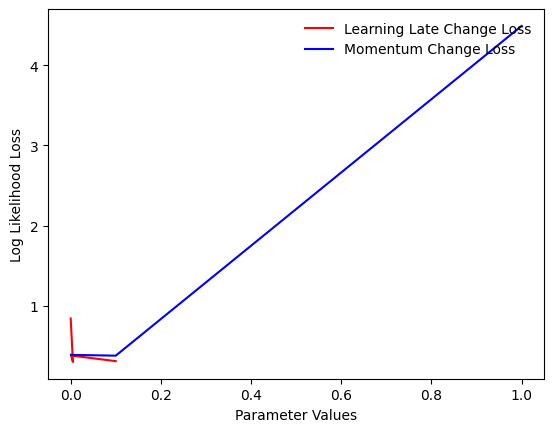

In [47]:
fig = pl.figure()
pl.plot(learning_rate_values, losses_lr[3::4], color='red')
pl.plot(momentum_vals, losses_momentum[3::4], color='blue')

pl.legend(['Learning Late Change Loss', 'Momentum Change Loss'], loc='upper right', frameon=False)
pl.xlabel('Parameter Values')
pl.ylabel('Log Likelihood Loss')

pl.show()